# 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
def generate_weighted_adjacency(
    N=2000, NE=1600, NI=400, p=0.1, w_EE=0.04, w_EI=0.98, w_IE=-0.3, w_II=-0.3
):
    """
    Generates a weighted adjacency matrix for a spiking neural network.

    Parameters:
        N (int): Total number of neurons
        NE (int): Number of excitatory neurons
        NI (int): Number of inhibitory neurons
        p (float): Connection probability
        w_EE (float): Weight for Excitatory-Excitatory connections
        w_EI (float): Weight for Excitatory-Inhibitory connections
        w_IE (float): Weight for Inhibitory-Excitatory connections
        w_II (float): Weight for Inhibitory-Inhibitory connections

    Returns:
        torch.Tensor: Weighted adjacency matrix (N x N)
    """
    # Create a random connectivity matrix
    adjacency_matrix = (torch.rand(N, N) < p).float()

    # Ensure no self-connections
    adjacency_matrix.fill_diagonal_(0)

    # Define indices for neuron types
    exc_idx = slice(0, NE)  # First NE are excitatory
    inh_idx = slice(NE, N)  # Remaining NI are inhibitory

    # Assign weights based on connection type
    weighted_matrix = torch.zeros((N, N))
    weighted_matrix[exc_idx, exc_idx] = (
        adjacency_matrix[exc_idx, exc_idx] * w_EE
    )  # E->E
    weighted_matrix[exc_idx, inh_idx] = (
        adjacency_matrix[exc_idx, inh_idx] * w_EI
    )  # E->I
    weighted_matrix[inh_idx, exc_idx] = (
        adjacency_matrix[inh_idx, exc_idx] * w_IE
    )  # I->E
    weighted_matrix[inh_idx, inh_idx] = (
        adjacency_matrix[inh_idx, inh_idx] * w_II
    )  # I->I

    return weighted_matrix

In [407]:
def scaled_sigmoid(x):
    x0 = 1e-5  # Center around x0
    raw_sigmoid = torch.sigmoid(x - x0)  # Shifted sigmoid
    return raw_sigmoid  # Scale to range


class SLM(torch.nn.Module):

    def __init__(
        self,
        f: float,
        eta_ud: float,
        eta_bu: float,
        beta: float,
        h: float,
    ):
        super().__init__()

        # Simulation parameters
        self.h = torch.tensor(h)
        self.sqrt_h = torch.sqrt(self.h)

        # LFP parameters
        self.a = -5
        self.beta = beta * self.sqrt_h
        self.f = f * 2 * torch.pi

        # Spike parameters
        self.A = generate_weighted_adjacency()
        self.N = len(self.A)
        self.Ne = int(0.8 * self.N)
        self.Ni = self.N - self.Ne
        
        self.vr = -70
        self.vth = -50
        self.tau_ex = 20
        self.tau_in = 10
        self.tref = 0
        self.tau = torch.ones(self.N)
        self.tau[:self.Ne] = self.tau_ex
        self.tau[self.Ne:] = self.tau_in

        # Noise
        R = 50.0  # Membrane resistence in Mohm
        sigma = 2.12  # Noise variance
        Cm = self.tau / R
        self.Cm = Cm
        x_ex = torch.exp(-self.h / self.tau)

        self.mu_v = torch.zeros(self.N)
        self.mu_v[:self.Ne] =  torch.tensor((14.2 / R))
        self.mu_v[self.Ne:] =  torch.tensor((15.7 / R))

        self.sigma_v = sigma * (Cm / self.tau) * torch.sqrt((1 + x_ex) / (1 - x_ex))
        print(self.tau)
        # LFP-spike connection parameterds
        self.eta_ud = eta_ud
        self.eta_bu = eta_bu

        print(f"ud = {self.eta_ud}")
        print(f"bu = {self.eta_bu}")

    def __ode_lfp(self, z: torch.Tensor, a: torch.Tensor, w: torch.Tensor):
        return z * (a + 1j * w - torch.abs(z) ** 2)

    def __ode_spikes(self, v: torch.Tensor, vr: torch.Tensor, tau: torch.Tensor):
        return -(v - vr) / tau

    def loop(self,  z_t: torch.Tensor, v_t: torch.Tensor, x_t: torch.Tensor, d_t: torch.Tensor):

        # integrate lfp
        z_t = (
            z_t
            + self.h * self.__ode_lfp(z_t, self.a, self.f)
            + self.beta * torch.randn(z_t.shape)
            + self.beta * 1j * torch.randn(z_t.shape)
            + self.sqrt_h * self.eta_bu * torch.sum(x_t) * 1j
        )

        # Check refractary
        d_t[d_t >= self.tref] = 0
        isref = np.logical_not(np.logical_and(d_t > 0, d_t < self.tref)).type(torch.bool)
        
        # integrate spikes
        v_t = (
            v_t
            + self.h * self.__ode_spikes(v_t, self.vr, self.tau)
            + self.sqrt_h * (self.mu_v + self.sigma_v * torch.randn(self.N))
            + self.h * (self.A * x_t).sum(1)
            + self.h * self.eta_ud * torch.relu(torch.real(z_t * 1e6)) / self.Cm
        )

        #v_t[self.Ne:] += self.h * self.eta_ud * torch.relu(torch.real(z_t * 1e6)) / self.Cm[self.Ne:]

        x_t = v_t >= self.vth
        v_t[x_t] = self.vr
        d_t[x_t] += self.h
        

        return z_t, v_t, x_t

    def forward(self, n_times: int, decim: int = 1):

        rec_z_t = torch.zeros(n_times // decim, dtype=torch.complex64)
        rec_v_t = torch.zeros(self.N, n_times // decim, dtype=torch.float32)
        rec_x_t = torch.zeros(self.N, n_times // decim, dtype=torch.int)

        z_t = self.h * torch.randn(1) + 1j * self.h * torch.randn(1)
        v_t = torch.FloatTensor(self.N).uniform_(-80, -70)
        x_t = torch.zeros(self.N)
        d_t = torch.zeros(self.N)

        t_rec = 0
        for t in range(n_times):
            z_t, v_t, x_t = self.loop(z_t, v_t, x_t, d_t)
            if not t % decim:
                rec_z_t[t_rec] = z_t
                rec_v_t[:, t_rec] = v_t
                rec_x_t[:, t_rec] = x_t
                t_rec = t_rec + 1

        return rec_z_t, rec_v_t, rec_x_t

In [425]:
model = SLM(15, 5e-2, 1e-1, 1e-4, 1e-4)

tensor([20., 20., 20.,  ..., 10., 10., 10.])
ud = 0.05
bu = 0.1


In [426]:
out = model(50000, 10)

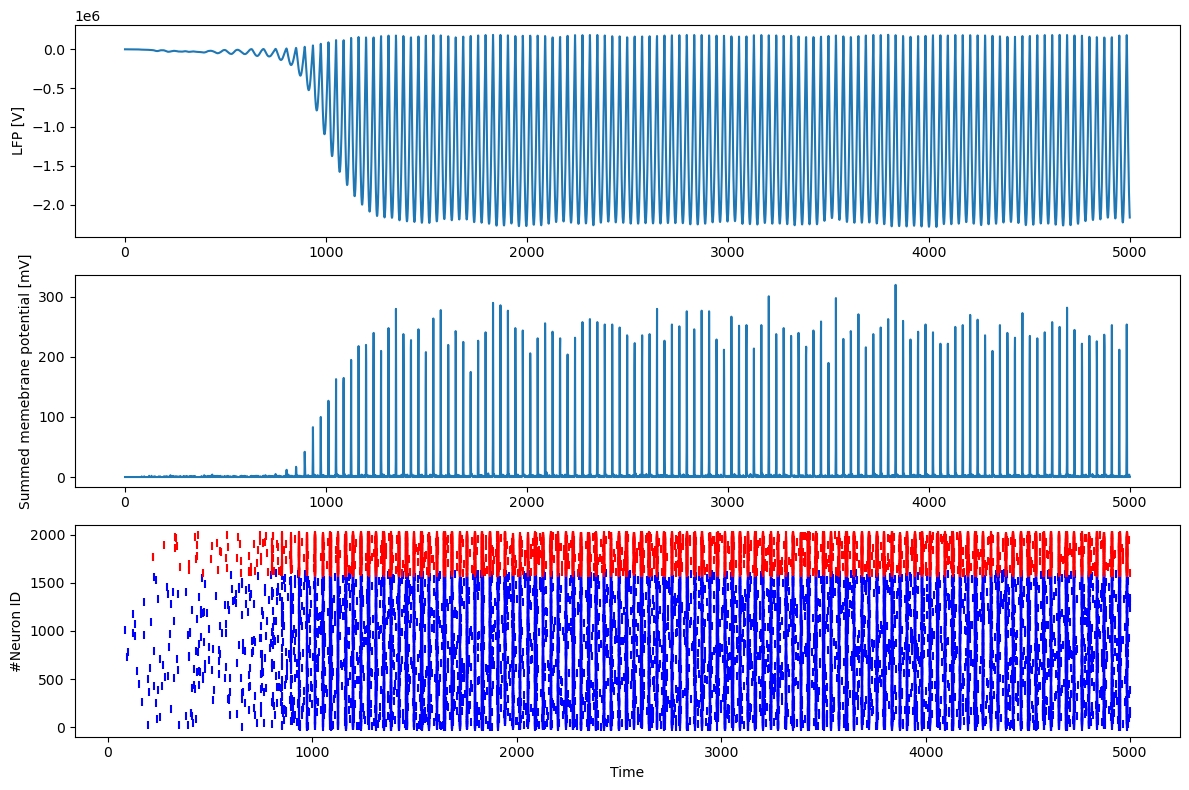

In [427]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(out[0].real * 1e6)
plt.ylabel("LFP [V]")
plt.subplot(312)
plt.plot(out[2].sum(0) )
plt.ylabel("Summed memebrane potential [mV]")
plt.subplot(313)
t = np.linspace(0, 5000, out[0].shape[0])
for pos, line in enumerate(out[2]):
    if pos < 1600:
        c = "b"
    else:
        c = "r"
    plt.scatter(t[torch.where(line)[0]], [pos] * line.sum(), marker="|", c=c)

plt.ylabel("#Neuron ID")
plt.xlabel("Time")
plt.tight_layout()

In [428]:
from mne.time_frequency.tfr import tfr_array_morlet

In [429]:
freqs = np.linspace(.1, 80, 100)


psd = tfr_array_morlet(
    out[0][None, None, ...],
    (1 / 1e-4) / 10,
    freqs,
    n_cycles=freqs / 4,
    decim=10,
    output="power",
).squeeze()

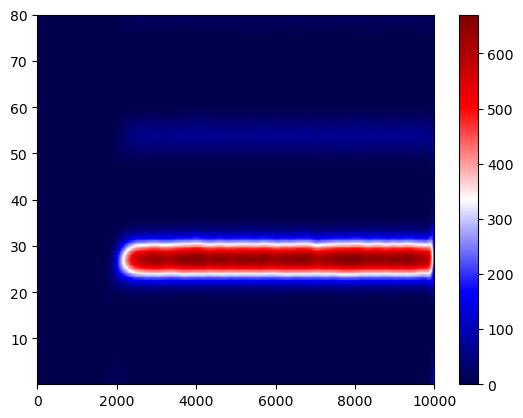

In [430]:
plt.imshow(
    #(psd - psd.mean(0, keepdims=True)) / psd.std(0, keepdims=True),
    psd,
    aspect="auto",
    cmap="seismic",
    origin="lower",
    extent=[0, 10000, .1, 80],
)
plt.colorbar()

In [388]:
def sigmoid_function(x, x0, k=1.0):
    # Define the sigmoid function using the logistic formula
    return 1 / (1 + torch.exp(-k * (x - x0)))

# Example usage:
N = 10  # Define the upper bound
x = torch.tensor([0, 2.5, 5, 7.5, 10], dtype=torch.float32)  # Example tensor

# Apply the sigmoid function
result = sigmoid_function(x, N)

print(result)

tensor([4.5398e-05, 5.5278e-04, 6.6929e-03, 7.5858e-02, 5.0000e-01])


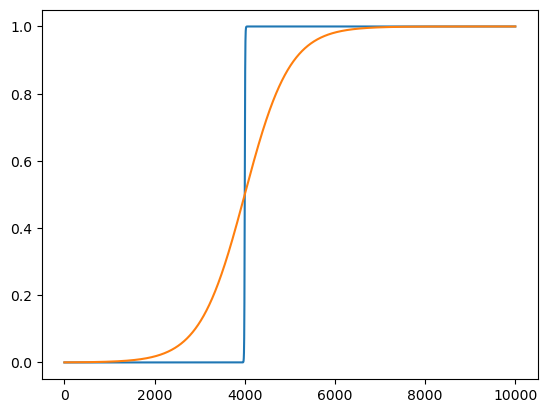

In [103]:
x = torch.linspace(0, 2000, 10000)
plt.plot(sigmoid_function(x, 800, 1))
plt.plot(sigmoid_function(x, 800, .01))